In [53]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import parzen , welch
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ARIMA
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox


In [54]:
# Read the data file into a pandas dataframe
FedFund_df = pd.read_csv("C:/Users/ndixit/Documents/NehaDixit/Capstone/FEDFUNDS_endDec2023.csv")
IndustryTitles_df = pd.read_csv("C:/Users/ndixit/Documents/NehaDixit/Capstone/IndustryTitlesRefined - Sheet1.csv")
#PCE_df = pd.read_csv("C:/Users/ndixit/Documents/NehaDixit/Capstone/PCE_endNov2023.csv")
PCE_df = pd.read_csv("C:/Users/ndixit/Documents/NehaDixit/Capstone/PCE.csv")
PCE_filter_df = PCE_df[PCE_df['description'].astype(str).str.strip() == 'Personal consumption expenditures (PCE)']
#print(PCE_filter_df)
Unemploy_df = pd.read_csv("C:/Users/ndixit/Documents/NehaDixit/Capstone/Unemployment_endDec2023-sub.csv")
FedFund_sub_df = FedFund_df.iloc[55:]
Unemploy_df.columns = ['observation_date','UR']
Unemploy_sub_df = Unemploy_df.iloc[133:]

In [55]:
#basic data exploration   
print(FedFund_df.head())
print(IndustryTitles_df.head())
print(Unemploy_df.head())

print(PCE_filter_df.head())
print(FedFund_sub_df.head())
print(Unemploy_sub_df.head())

  observation_date  FEDFUNDS
0         7/1/1954      0.80
1         8/1/1954      1.22
2         9/1/1954      1.07
3        10/1/1954      0.85
4        11/1/1954      0.83
   industry_code                                     industry_title
0             11  NAICS 11 Agriculture, forestry, fishing and hu...
1             21  NAICS 21 Mining, quarrying, and oil and gas ex...
2             22                                 NAICS 22 Utilities
3             23                              NAICS 23 Construction
4            311                       NAICS 311 Food manufacturing
  observation_date   UR
0         1/1/1948  3.4
1         2/1/1948  3.8
2         3/1/1948  4.0
3         4/1/1948  3.9
4         5/1/1948  3.5
  observation_date                                      description  PCE
0         2/1/1959          Personal consumption expenditures (PCE)  0.1
1         3/1/1959          Personal consumption expenditures (PCE)  0.1
2         4/1/1959          Personal consumption expend

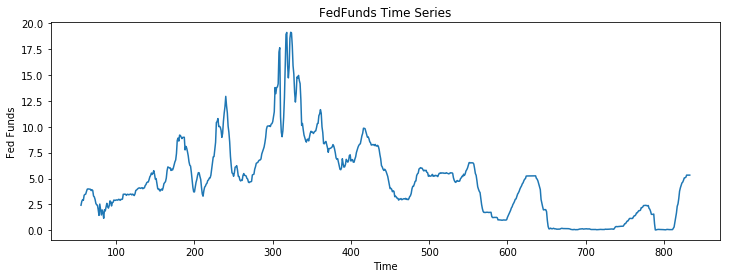

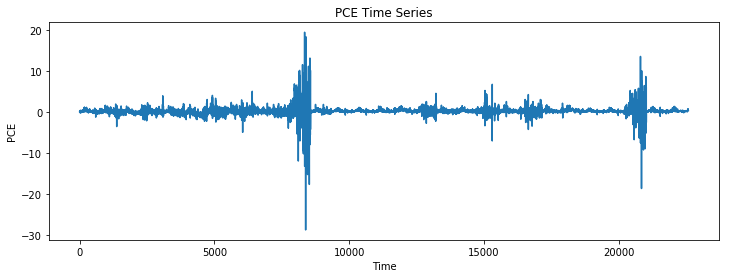

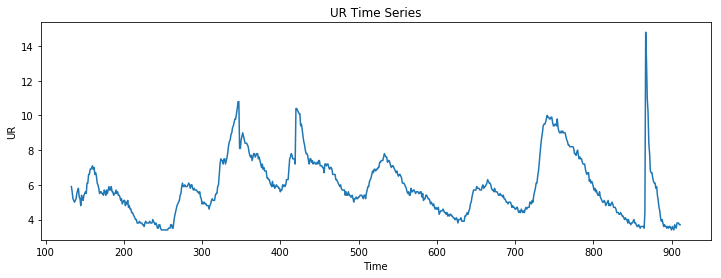

    observation_date  FEDFUNDS  \
0           2/1/1959      2.43   
1           3/1/1959      2.80   
2           4/1/1959      2.96   
3           5/1/1959      2.90   
4           6/1/1959      3.39   
5           7/1/1959      3.47   
6           8/1/1959      3.50   
7           9/1/1959      3.76   
8          10/1/1959      3.98   
9          11/1/1959      4.00   
10         12/1/1959      3.99   
11          1/1/1960      3.99   
12          2/1/1960      3.97   
13          3/1/1960      3.84   
14          4/1/1960      3.92   
15          5/1/1960      3.85   
16          6/1/1960      3.32   
17          7/1/1960      3.23   
18          8/1/1960      2.98   
19          9/1/1960      2.60   
20         10/1/1960      2.47   
21         11/1/1960      2.44   
22         12/1/1960      1.98   
23          1/1/1961      1.45   
24          2/1/1961      2.54   
25          3/1/1961      2.02   
26          4/1/1961      1.49   
27          5/1/1961      1.98   
28          6/

In [56]:
# Plotting the target variable 'Fed Funds' 
# timeseries plot
plt.figure(figsize=(12, 4)) 
plt.plot(FedFund_sub_df['FEDFUNDS']) 
plt.xlabel('Time') 
plt.ylabel('Fed Funds') 
plt.title('FedFunds Time Series') 
plt.show() 

#plotting the variables vs time

plt.figure(figsize=(12, 4)) 
plt.plot(PCE_df['PCE']) 
plt.xlabel('Time') 
plt.ylabel('PCE') 
plt.title('PCE Time Series') 
plt.show() 

plt.figure(figsize=(12, 4)) 
plt.plot(Unemploy_sub_df['UR']) 
plt.xlabel('Time') 
plt.ylabel('UR') 
plt.title('UR Time Series') 
plt.show() 

#combined_df = pd.concat([ FedFund_sub_df,PCE_df ]), axis=1)
combined_df1 = pd.merge(FedFund_sub_df,PCE_filter_df,how ='outer')
combined_df = (pd.merge(combined_df1, Unemploy_sub_df , how ='outer')).iloc[0:778]
print(combined_df)

<Figure size 864x288 with 0 Axes>

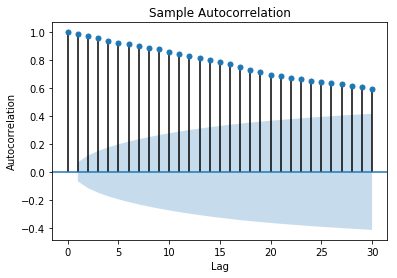

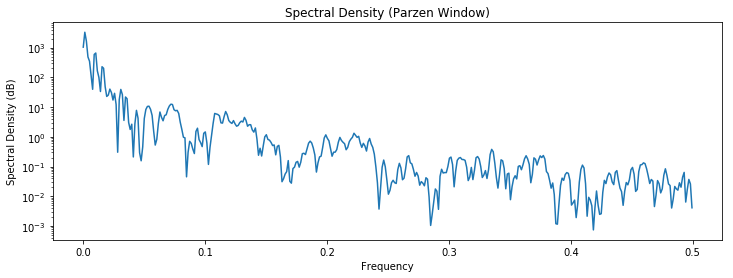

In [57]:
#sample autocorrelation (ACF) plot 

plt.figure(figsize=(12, 4)) 
plot_acf(FedFund_df['FEDFUNDS'], lags = 30) 
plt.xlabel('Lag') 
plt.ylabel('Autocorrelation') 
plt.title('Sample Autocorrelation') 
plt.show()

#Spectral density( Parzen Window) plot

window = parzen(len(FedFund_sub_df['FEDFUNDS']))
freqs , psd = welch(FedFund_sub_df['FEDFUNDS'], window=window , nperseg = len(FedFund_sub_df['FEDFUNDS']))

plt.figure(figsize=(12,4))
plt.semilogy(freqs, psd)
plt.xlabel('Frequency')
plt.ylabel('Spectral Density (dB)')
plt.title('Spectral Density (Parzen Window)')
plt.show()

In [58]:
#Dickey Fuller stationarity test

def adf_test(series):
    print('Results Dickey-Fuller Test')
    adf_result = adfuller(series)
    output = pd.Series(adf_result[0:4], index=['Test Stats','p-value','Lags used','Observations Used'])
    for key, value in adf_result[4].items():
        output['Critical value({key})'] = value
        
    print(output)
    
    if adf_result[1] <= .05:
        print("Strong evidence against null hypothesis, reject null hypothesis. Data stationary")
    else:
        print("Time series has unit roots, non stationary")
        
#Test each series
adf_test(combined_df['FEDFUNDS'])
adf_test(combined_df['PCE'])
adf_test(combined_df['UR'])

Results Dickey-Fuller Test
Test Stats                -2.899032
p-value                    0.045461
Lags used                 17.000000
Observations Used        760.000000
Critical value({key})     -2.568799
dtype: float64
Strong evidence against null hypothesis, reject null hypothesis. Data stationary
Results Dickey-Fuller Test
Test Stats                -2.896490
p-value                    0.045758
Lags used                 14.000000
Observations Used        763.000000
Critical value({key})     -2.568791
dtype: float64
Strong evidence against null hypothesis, reject null hypothesis. Data stationary
Results Dickey-Fuller Test
Test Stats                -3.209594
p-value                    0.019436
Lags used                  4.000000
Observations Used        773.000000
Critical value({key})     -2.568765
dtype: float64
Strong evidence against null hypothesis, reject null hypothesis. Data stationary


In [59]:
##Multi Variate Regression 
Xreg= data[['PCE','UR']]
#add constants to model
X= sm.add_constant(data[['PCE','UR']])

ksfit = sm.OLS(data['FEDFUNDS'],X).fit()

#aic calculation
def calculate_aic(model_resid, k): 
    """Calculates AIC given model residuals and number of parameters.""" 
    n = len(model_resid) 
    sse = np.sum(model_resid**2) 
    return 2*k + n * np.log(sse/n)

aic_values = [] 
for p in np.arange(9): 
    fit_temp = ARIMA(data['FEDFUNDS'], order=(p, 0, 0), exog=Xreg).fit(disp=0) 
    aic_values.append(calculate_aic(fit_temp.resid, p + 1)) 

best_p = np.argmin(aic_values)

# ARIMA model

fit = ARIMA(data['FEDFUNDS'], order =(best_p,0,0),exog=Xreg).fit()

print(fit.summary())

#Ljung-Box test
ltest =acorr_ljungbox(fit.resid, lags = None)
p_values =ltest[1]

print(p_values)

#Results
#1. The errors in the standard multiple regression satisfy AR(8) and are correlated
#2.None of the variables PCE, UR are significantly different from zero( coeff of PCE -.1095 and UR -0.505 are not statistically significant)
#This means there is not enough evidence to conclude that the changes in PCE or UR have a reliable effect on FEDFUNDS
#3. All the AR terms except ar.L6.FEDFUNDS are statistically significant (p-value <0.05) whcih means past value of FEDFUNDS are inmportant in predicting current value.
#4. Roots of characteristic polynomial ( all modulus less than 1) indicate model is stationary, which is desirable
#Given many of the  p-values from Ljung-Box Testfor lower lags are below significance level (.05), 
#this indicates rejection of null hypothesis( i.e. there is no autocorrelation in residuals). Hence, we can conclude there is significant
#autocorrelation present in the residuals of ARIMA model. This means the existing model hasn't fully captured the underlying patterns in data

# The presence of autocorrelation suggests that ARMA(8,0) model is likely not th best and that there are still patterns that the model is not accounting for.

## Conclusion : The below results are not very encouraging and hence trying a time trend element


C:\Users\ndixit\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\ndixit\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ndixit\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ndixit\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Us

                              ARMA Model Results                              
Dep. Variable:               FEDFUNDS   No. Observations:                  772
Model:                     ARMA(8, 0)   Log Likelihood                -477.505
Method:                       css-mle   S.D. of innovations              0.448
Date:                Sat, 25 May 2024   AIC                            979.009
Time:                        07:39:04   BIC                           1034.797
Sample:                             0   HQIC                          1000.477
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.0246      1.504      3.341      0.001       2.077       7.972
PCE               -0.1118      0.066     -1.698      0.090      -0.241       0.017
UR                -0.0504      0.033

In [60]:
##Multiple Regression with Trend
##Multi Variate Regression 

data['trend']= range(1,len(data)+1)

Xreg= data[['PCE','UR', 'trend']]
#add constants to model
X= sm.add_constant(data[['PCE','UR','trend']])

ksfit = sm.OLS(data['FEDFUNDS'],X).fit()

#aic calculation
def calculate_aic(model_resid, k): 
    """Calculates AIC given model residuals and number of parameters.""" 
    n = len(model_resid) 
    sse = np.sum(model_resid**2) 
    return 2*k + n * np.log(sse/n)

aic_values = [] 
for p in np.arange(15): 
    fit_temp = ARIMA(data['FEDFUNDS'], order=(p, 0, 0), exog=Xreg).fit(disp=0) 
    aic_values.append(calculate_aic(fit_temp.resid, p + 1)) 

best_p = np.argmin(aic_values)

# ARIMA model

fit = ARIMA(data['FEDFUNDS'], order =(best_p,0,0),exog=Xreg).fit()

print(fit.summary())

#Ljung-Box test
ltest =acorr_ljungbox(fit.resid, lags = None)
p_values =ltest[1]

print(p_values)

##Results 
# 1. Coeffcients of PCE, UR, trend are not statistically significant which suggests variable don't have significant impact on FEDFUNDS
# in this model
# 2. adding trend doesn't seem to improve model



C:\Users\ndixit\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ndixit\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ndixit\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ndixit\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\U

                              ARMA Model Results                              
Dep. Variable:               FEDFUNDS   No. Observations:                  772
Model:                    ARMA(14, 0)   Log Likelihood                -437.210
Method:                       css-mle   S.D. of innovations              0.425
Date:                Sat, 25 May 2024   AIC                            912.420
Time:                        07:43:44   BIC                           1000.751
Sample:                             0   HQIC                           946.410
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.0765      1.857      3.811      0.000       3.437      10.716
PCE                -0.0482      0.060     -0.797      0.426      -0.167       0.070
UR                 -0.0304      

In [61]:
## Multiple Regression with lagged variable

#Create lagged variable( lag variable by 1 period)
data['PCE1'] = data['PCE'].shift(1)
data['UR1'] = data['UR'].shift(1)


#add constants to model
X= sm.add_constant(data[['PCE1','UR1']])

ksfit = sm.OLS(data['FEDFUNDS'], X).fit()

Xreg= data[['PCE1','UR1']].dropna()

#aic calculation
def calculate_aic(model_resid, k): 
    """Calculates AIC given model residuals and number of parameters.""" 
    n = len(model_resid) 
    sse = np.sum(model_resid**2) 
    return 2*k + n * np.log(sse/n)

aic_values = [] 
for p in np.arange(9): 
    fit_temp = ARIMA(data['FEDFUNDS'], order=(p, 0, 0), exog=Xreg).fit(disp=0) 
    aic_values.append(calculate_aic(fit_temp.resid, p + 1)) 

min_aic_index = np.argmin(aic_values)
best_p = np.argmin(aic_values)



# ARIMA model

fit = ARIMA(data['FEDFUNDS'].loc[Xreg.index], order =(best_p,0,0),exog=Xreg).fit()

print(fit.summary())

#Ljung-Box test
ltest =acorr_ljungbox(fit.resid, lags = None)
p_values =ltest[1]

print(p_values)


MissingDataError: exog contains inf or nans

In [ ]:
#Fit VAR model

data = combined_df
data_sm = combined_df[0:750]

print(data_sm .tail())
data_sm =data_sm[['FEDFUNDS','PCE','UR']]
model_var =VAR(data_sm)
results_var =model_var.select_order(maxlags = 5)
print(results_var.summary())

lag_order = results_var.selected_orders['aic']
model_fitted_var = model_var.fit(lag_order)
print(model_fitted_var.summary())

## Results 
#1. The model with 5 lags (VAR(5)) is selected because it minimizes the AIC,
#indicating a good balance between model fit and complexity

#2. L1.FEDFUNDS, L2.FEDFUNDS: These coefficients represent the effects of the first and second lags of FEDFUNDS on its current value. Both are highly significant, indicating a strong autoregressive component.
#3. L1.PCE: This coefficient represents the effect of the first lag of PCE on the current FEDFUNDS rate. It's statistically significant (p-value = 0.001), suggesting that past changes in personal consumption expenditures influence the Federal Funds Rate.
#4. vL1.PCE: This coefficient represents the effect of the first lag of PCE on the current FEDFUNDS rate. It's statistically significant (p-value = 0.001), suggesting that past changes in personal consumption expenditures influence the Federal Funds Rate.

In [ ]:
#Forecast
forecast_steps = 10
forecast_input = data_sm.values[-lag_order:]
fc = model_fitted_var.forecast(y=forecast_input , steps=forecast_steps)
print(data_sm.index[-1])
#convert results into DF
fc_df =pd.DataFrame(fc,index=pd.date_range(start = data_sm.index[-1], periods = forecast_steps, freq='MS'),columns=['FEDFUNDS_Forecast','PCE_Forecast','UR_Forecast'])
### Fix index
fedfunds_forecast =fc_df['FEDFUNDS_Forecast']
print(fedfunds_forecast)


In [ ]:
### Model performances
ASE
##Forecast plots

In [ ]:
#create lagged features for PCE and UR
for i in range(1,4):
    data[f'PCE_lag_{i}'] = data['PCE'].shift(i)
    data[f'UR_lag_{i}'] = data['UR'].shift(i)
    
#drop na from lag
data=data.dropna()

# X, Y
X = data[['PCE', 'UR','PCE_lag_1','PCE_lag_2','PCE_lag_3','UR_lag_1','UR_lag_2','UR_lag_3']]
Y = data['FEDFUNDS']

#split training and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size =0.2, shuffle = 'false')

#Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Model creation MLP
mlp = MLPRegressor(hidden_layer_sizes=(100,50),max_iter=10)

#train model
mlp.fit(X_train, Y_train)

#prediction

Y_pred = mlp.predict(X_test)

#Evaluate model

mse = mean_squared_error(Y_test,Y_pred)
print(mse)


            

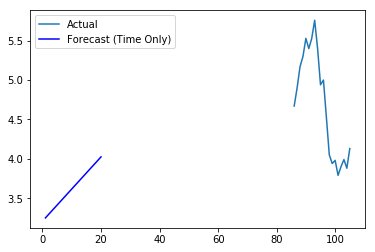

ASE (Time Only): 1.8421174748499758


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [64]:
# 1. Only Time as a Regressor (Using MLPRegressor for neural network)
model1 = MLPRegressor(random_state=2)
model1.fit(np.arange(1, 81).reshape(-1, 1), data['FEDFUNDS'][0:80])  # Fit on time indices 
forecast1 = model1.predict(np.arange(81, 101).reshape(-1, 1))

plt.plot(data['FEDFUNDS'][80:100], label='Actual')
plt.plot(range(1, 21), forecast1, label='Forecast (Time Only)', color='blue')
plt.legend()
plt.show()
ASE1 = mean_squared_error(data['FEDFUNDS'][80:100], forecast1)
print("ASE (Time Only):", ASE1)


# 2. With Additional Regressors (Using MLPRegressor for neural network)
X_train = pd.DataFrame({
    'PCE': data['PCE'][0:80],
    'UR': data['UR'][0:80]
})
y_train = data['FEDFUNDS'][0:80]
model2 = MLPRegressor(random_state=2)
model2.fit(X_train, y_train)

X_test = pd.DataFrame({
    'PCE': data['PCE'][80:100],
    'UR': data['UR'][80:100]
})

######################## In progress
#check for missing values
print(X_train.isnull().sum())
print(y_train.isnull().sum())

# Replace Nans
X_train['PCE'].fillna(X_train['PCE'].mean().inplace=True)
X_train['UR'].fillna(X_train['UR'].mean().inplace=True)

y_train.fillna(y_train.mean(),inplace = True)

print(X_train.isinf().sum())
print(y_train.isinf().sum())

# Replace Nans
X_train.replace([np.inf, -np.inf] , np.nan, inpace = True)
X_train[['PCE','UR']].fillna(X_train['PCE','UR'].mean().inplace=True)

###################



forecast2 = model2.predict(X_test)

plt.plot(data['FEDFUNDS'][80:100], label='Actual')
plt.plot(range(1, 21), forecast2, label='Forecast (With Regressors)', color='blue')
plt.legend()
plt.show()
ASE2 = mean_squared_error(data['FEDFUNDS'][80:100], forecast2)
print("ASE (With Regressors):", ASE2)

# 3. ARIMA Model with Regressors
# (Assuming you have the statsmodels package installed)
data['PCE1'] = data['PCE'].shift(1)  # Create lagged variables
data['UR1'] = data['UR'].shift(1)

# (Code for AIC selection is not directly translatable, you'd use statsmodels for this)
# Let's assume p=7 as per your AIC result
model3 = ARIMA(data['FEDFUNDS'][0:80], order=(7, 0, 0), exog=data[['PCE1', 'UR1']][0:80])
model3_fit = model3.fit()

forecast3 = model3_fit.get_forecast(steps=20, exog=data[['PCE1', 'UR1']][80:100]).predicted_mean

plt.plot(data['FEDFUNDS'][80:100], label='Actual')
plt.plot(range(1, 21), forecast3, label='Forecast (ARIMA)', color='blue')
plt.legend()
plt.show()
ASE3 = mean_squared_error(data['FEDFUNDS'][80:100], forecast3)
print("ASE (ARIMA):", ASE3)

